In [13]:
vjhk = [-0.0053,3.5326, 1.3141, -3.8331]
# VJH = [0.2948, 4.2168, -3.2251]
# VJK = [0.0631, 3.7103, -2.7004]
# VHK = [1.4044, 12.1719,-11.2331]
# VJ = [3.8512, 0.7671]
# VH = [4.8834, 0.6895]
# VK = [5.1466, 0.6682]

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
from astropy.io import fits
import os
from astropy.timeseries import LombScargle
import glob
import pathlib
from astroquery.mast import Observations
from astropy import units as u
import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'white'
from astropy.coordinates import SkyCoord
from tqdm import tqdm
import pickle
import lightkurve as lk
import scipy.stats as stats
import traceback
from scipy.signal import find_peaks
from IPython.display import Image, display
import scipy
# import exoplanet as xo

In [52]:
all_stars_catalog = pd.read_csv('/Users/caleb/Downloads/asu(3).tsv',delimiter=';',index_col=0,skiprows=101)

In [ ]:
GJs

CNS5
5187     815.0
5321     834.0
5322     834.0
5353     836.8
5127     806.0
         ...  
912      146.0
819      132.0
906      145.0
919     1061.0
987     1066.0
Name: GJ, Length: 998, dtype: float64

In [17]:
def get_mass_from_mag(mag):
    return (0.2311-0.1352*(mag-7.5)+.0400*(mag-7.5)**2+0.0038*(mag-7.5)**3-0.0032*(mag-7.5)**4)

In [18]:
def is_float(s):
    try:
        float_value = float(s)
        return True
    except ValueError:
        return False

In [104]:
kmags = all_stars_catalog['Ksmag']
hmags = kmags = all_stars_catalog['Hmag']
jmags = kmags = all_stars_catalog['Jmag']

In [160]:
present_kmags_indices = [i for i, x in enumerate(kmags) if is_float(x)==True]
present_jmags_indices = [i for i, x in enumerate(jmags) if is_float(x)==True]
present_hmags_indices = [i for i, x in enumerate(hmags) if is_float(x)==True]

actually_present = []
for i in present_hmags_indices:
    if is_float(all_stars_catalog['Ksmag'][i]):
        actually_present.append(i)

stars_with_mags = all_stars_catalog.iloc[actually_present]

stars_with_mags['Ksmag'] = [float(i) for i in stars_with_mags['Ksmag']]
stars_with_mags['Hmag'] = [float(i) for i in stars_with_mags['Hmag']]
stars_with_mags['Jmag'] = [float(i) for i in stars_with_mags['Jmag']]

stars_with_mags = stars_with_mags[(stars_with_mags['Ksmag']<10) & (stars_with_mags['Ksmag']>5)]

vmags = np.array(vjhk[0] + vjhk[1]*stars_with_mags['Jmag'] + vjhk[2]*stars_with_mags['Hmag'] + vjhk[3]*stars_with_mags['Ksmag'])

stars_with_mags['Mass'] = get_mass_from_mag(stars_with_mags['Ksmag'])
stars_with_mags['distance']=[1000/float(i) for i in np.array(stars_with_mags['plx'])]

# just keep ones with mass >.3M 
stars_with_mags = stars_with_mags[stars_with_mags["Mass"]>.3]

ras = [float(i) for i in stars_with_mags['RAJ2000']]
decs = [float(i) for i in stars_with_mags['DEJ2000']]



/var/folders/8w/z7zsz3tj76jd_p19pfzbwj5c0000gn/T/ipykernel_1184/2213177231.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars_with_mags['Ksmag'] = [float(i) for i in stars_with_mags['Ksmag']]
/var/folders/8w/z7zsz3tj76jd_p19pfzbwj5c0000gn/T/ipykernel_1184/2213177231.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stars_with_mags['Hmag'] = [float(i) for i in stars_with_mags['Hmag']]
/var/folders/8w/z7zsz3tj76jd_p19pfzbwj5c0000gn/T/ipykernel_1184/2213177231.py:14: SettingWithCopyWarning: 
A value

In [205]:
len(np.array(stars_with_mags['SimbadName']))

998

In [214]:
all_stars_catalog.columns

Index(['GJ', 'Comp', 'NComp', 'P?', 'GJp', 'GaiaDR3', 'HIP', 'RAJ2000',
       'DEJ2000', 'Epoch', 'plx', 'pmRA', 'pmDE', 'RV', 'Gmag', 'BPmag',
       'RPmag', 'GHIPmag', 'G-RPHIP', 'Gmagr', '(G-RP)r', 'f_(G-RP)r', 'Jmag',
       'Hmag', 'Ksmag', 'W1mag', 'W2mag', 'W3mag', 'W4mag', 'SimbadName'],
      dtype='object')

In [216]:
all_stars_catalog[5488:5492][['Gmag','Gmagr']]

,Gmag,Gmagr
CNS5,,
5232,14.2586460,14.258646
5257,10.0702877,10.070288
5277,4.0891333,4.089133
5203,11.5499868,11.549987


In [212]:
list(np.array(all_stars_catalog['SimbadName'])).index('HIP 105858')

5490

In [170]:
stars_with_mags.to_csv('all_stars_mags_mass.csv')

In [165]:
coords = []
for i in range(len(decs)):
    coords.append(f"{ras[i]}"+" "+f"{decs[i]}")

In [139]:
# load RA and DECs we already have
m_dwarf_sample = pd.read_csv('/Users/caleb/research/Astro_98/m_dwarf_sample_with_files_powers.csv',delimiter=',',index_col=0)
m_ra = np.array(m_dwarf_sample[m_dwarf_sample.columns[0]])
m_dec = np.array(m_dwarf_sample[m_dwarf_sample.columns[1]])

m_ras = [i.replace(' ',':') for i in m_ra]
m_decs = [i.replace(' ',':') for i in m_dec]

m_coords = []
sky_coords_ras = []
sky_coords_decs = []

for i in range(len(m_decs)):
    m_coords.append(m_ras[i]+" "+m_decs[i])
    m_c =  SkyCoord(m_ras[i],m_decs[i], unit=(u.hourangle, u.deg))
    sky_coords_ras.append(m_c.ra.value)
    sky_coords_decs.append(m_c.dec.value)

In [206]:
with open(f'/Users/caleb/research/Astro_98/lightkurve_data/heavy_names.pkl','rb') as f:
    names = pickle.load(f)


In [185]:
with open(f'/Users/caleb/research/Astro_98/lightkurve_data/heavy_names.pkl','wb') as f:
    pickle.dump(names,f)


In [176]:
stars_with_mags[0:10]

,GJ,Comp,NComp,P?,GJp,GaiaDR3,HIP,RAJ2000,DEJ2000,Epoch,...,Jmag,Hmag,Ksmag,W1mag,W2mag,W3mag,W4mag,SimbadName,Mass,distance
CNS5,,,,,,,,,,,,,,,,,,,,,
5187,815,,,0,,1873073175244118784,103655,315.02594408686,+40.06906741776,2016.0000,...,6.668,6.089,5.880,5.810,5.570,5.590,5.449,HIP 103655,0.516904,15.017270
5321,834,B,2,0,,1953952387283004544,106694,324.15917419924,+39.45494611812,2016.0000,...,7.111,6.496,6.302,6.193,6.013,6.054,5.944,HIP 106694,0.437353,20.859408
5322,834,A,2,1,,1953952391581618432,106694,324.15953061030,+39.45499047105,2016.0000,...,7.111,6.496,6.302,6.193,6.013,6.054,5.944,HIP 106694,0.437353,20.772746
5353,836.8,,,0,,1954559047126247808,107346,326.12447685375,+41.59764417178,2016.0000,...,7.070,6.422,6.289,6.187,6.134,6.201,6.121,HIP 107346,0.439857,19.825535
5127,806,,,0,,2070115588901082368,102401,311.26978468219,+44.50027266840,2016.0000,...,7.329,6.769,6.533,6.409,6.169,6.239,6.296,HIP 102401,0.393008,12.059817
5201,816.1,A,2,1,,2163558855915068416,103859,315.67240371913,+45.88539608945,2016.0000,...,5.944,6.953,5.372,,,,,HIP 103859,0.597703,19.447686
5152,4167,,,0,,2182197777015312512,102870,312.63992950208,+52.90154631022,2016.0000,...,7.236,6.619,6.480,,,,,HIP 102870,0.403124,22.758307
5620,873,,,0,,1934263333784036736,112460,341.70282545224,+44.33195332332,2016.0000,...,6.106,5.554,5.299,5.202,4.716,4.904,4.750,HIP 112460,0.606835,5.050505
5711,13330,A,2,1,,1935133906477014016,114456,347.70810989568,+45.51099625165,2016.0000,...,5.646,5.346,5.281,5.245,5.107,5.276,5.230,HIP 114456,0.608962,23.534949


In [183]:
names = np.array(stars_with_mags["SimbadName"])

In [184]:
names

array(['HIP 103655', 'HIP 106694', 'HIP 106694', 'HIP 107346',
       'HIP 102401', 'HIP 103859', 'HIP 102870', 'HIP 112460',
       'HIP 114456', 'HIP 115341', 'HIP 115058', 'HIP 116613',
       'HIP 118162', 'HIP 109926', 'HIP 115562', 'HIP  95575',
       'HIP  96395', 'HIP  91128', 'HIP  89560',
       'Gaia DR3 2122104690545294208', 'HIP  94346', 'HIP 102101',
       'HIP 106400', 'HIP 101180', 'HIP 114066', 'HIP 113944',
       'HIP 109980', 'HIP 108467', 'Gaia DR3 2281114756485256704',
       'HIP 115147', 'HIP  99427', 'HIP 112527',
       'Gaia DR3 2287506148856660992', 'HIP    428',
       'Gaia DR3  386653747925624576', 'HIP    473',
       'Gaia DR3  392350008432819328', 'HIP   3008', 'HIP   4012',
       'HIP   6290', 'Gaia DR3  426641955043723520', 'HIP   4872',
       'HIP   9291', 'HIP  12886', 'Gaia DR3  240259375324767744',
       'HIP  15366', 'HIP  11048', 'Gaia DR3  438829835272390784',
       'Gaia DR3  440052423484915712', 'HIP  17491', 'HIP  17666',
       'Gaia

In [192]:
search_result = lk.search_lightcurve('315.025944086 +40.06906741776',mission='TESS')
search_result

No data found for target "315.025944086 +40.06906741776".


SearchResult containing 0 data products.

In [166]:
for coord in coords[0:10]:
    # want fast cadence data
    search_result = lk.search_lightcurve(coord,mission='TESS',exptime='fast')
    print(search_result)
    if len(search_result) > 0:
        lcs = search_result.download_all()

No data found for target "315.02594408686 40.06906741776".


SearchResult containing 0 data products.


No data found for target "324.15917419924 39.45494611812".


SearchResult containing 0 data products.
SearchResult containing 0 data products.
SearchResult containing 0 data products.


No data found for target "311.26978468219 44.5002726684".


SearchResult containing 0 data products.


No data found for target "315.67240371913 45.88539608945".


SearchResult containing 0 data products.


No data found for target "312.63992950208 52.90154631022".


SearchResult containing 0 data products.


No data found for target "341.70282545224 44.33195332332".


SearchResult containing 0 data products.
SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 57 2022   SPOC      20   455819325      0.0
SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 57 2022   SPOC      20   173924720      0.0


In [105]:
masses = get_mass_from_mag(present_kmags)

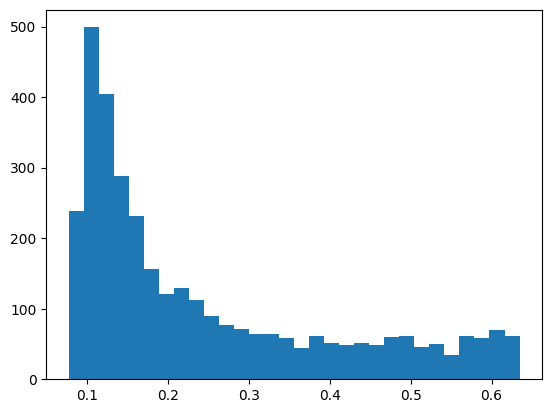

In [125]:
plt.hist(stars_with_mags['Mass'],bins=30)
plt.show()

(array([  3.,   0.,   2.,   2.,   9.,   7.,  10.,  13.,  30.,  27.,  45.,
         54.,  61.,  72., 100., 124., 138., 170., 174., 176., 191., 214.,
        274., 267., 314., 336., 282., 289., 243., 199.]),
 array([0.15      , 0.47826667, 0.80653333, 1.1348    , 1.46306667,
        1.79133333, 2.1196    , 2.44786667, 2.77613333, 3.1044    ,
        3.43266667, 3.76093333, 4.0892    , 4.41746667, 4.74573333,
        5.074     , 5.40226667, 5.73053333, 6.0588    , 6.38706667,
        6.71533333, 7.0436    , 7.37186667, 7.70013333, 8.0284    ,
        8.35666667, 8.68493333, 9.0132    , 9.34146667, 9.66973333,
        9.998     ]),
 <BarContainer object of 30 artists>)

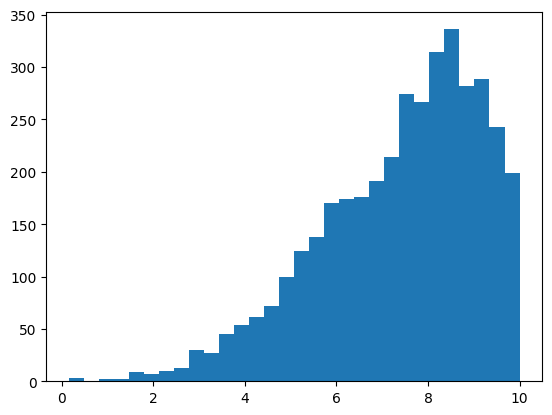

In [89]:
plt.hist(present_kmags,bins=30)

In [53]:
len(present_kmags_indices)

5320

In [30]:
present_kmags= [i.isspace() for i in kmags]

kmags[2001].isspace()

False

In [194]:
len(stars_with_mags)

998

In [201]:
## get paths

def get_paths(target):
    cwd = os.getcwd()
    current_dir = pathlib.Path(cwd)
    all_paths = []

    if target == '':
        for num in range(998):
            file_paths = [str(i) for i in list(current_dir.glob(f"lightkurve_data/heavy_data/{num}_*_lc.fits"))]
            all_paths.append(file_paths)

    else:
        file_paths = [str(i) for i in list(current_dir.glob(f"lightkurve_data/heavy_data/{target}_*_lc.fits"))]
        all_paths.append(file_paths)

    return all_paths

In [199]:
heavy_paths = get_paths('')

In [200]:
heavy_paths

[['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/0_0_lc.fits'],
 [],
 [],
 [],
 ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/4_0_lc.fits'],
 ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/5_0_lc.fits'],
 [],
 ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/7_0_lc.fits',
  '/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/7_1_lc.fits'],
 ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/8_0_lc.fits'],
 ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/9_0_lc.fits'],
 [],
 [],
 ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/12_0_lc.fits'],
 ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/13_1_lc.fits',
  '/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/13_0_lc.fits'],
 [],
 [],
 ['/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/16_3_lc.fits',
  '/Users/caleb/research/Astro_98/lightkurve_data/heavy_data/16_2_lc.fits',
  '/Users/caleb/research/Astro_98/lightkurve_da